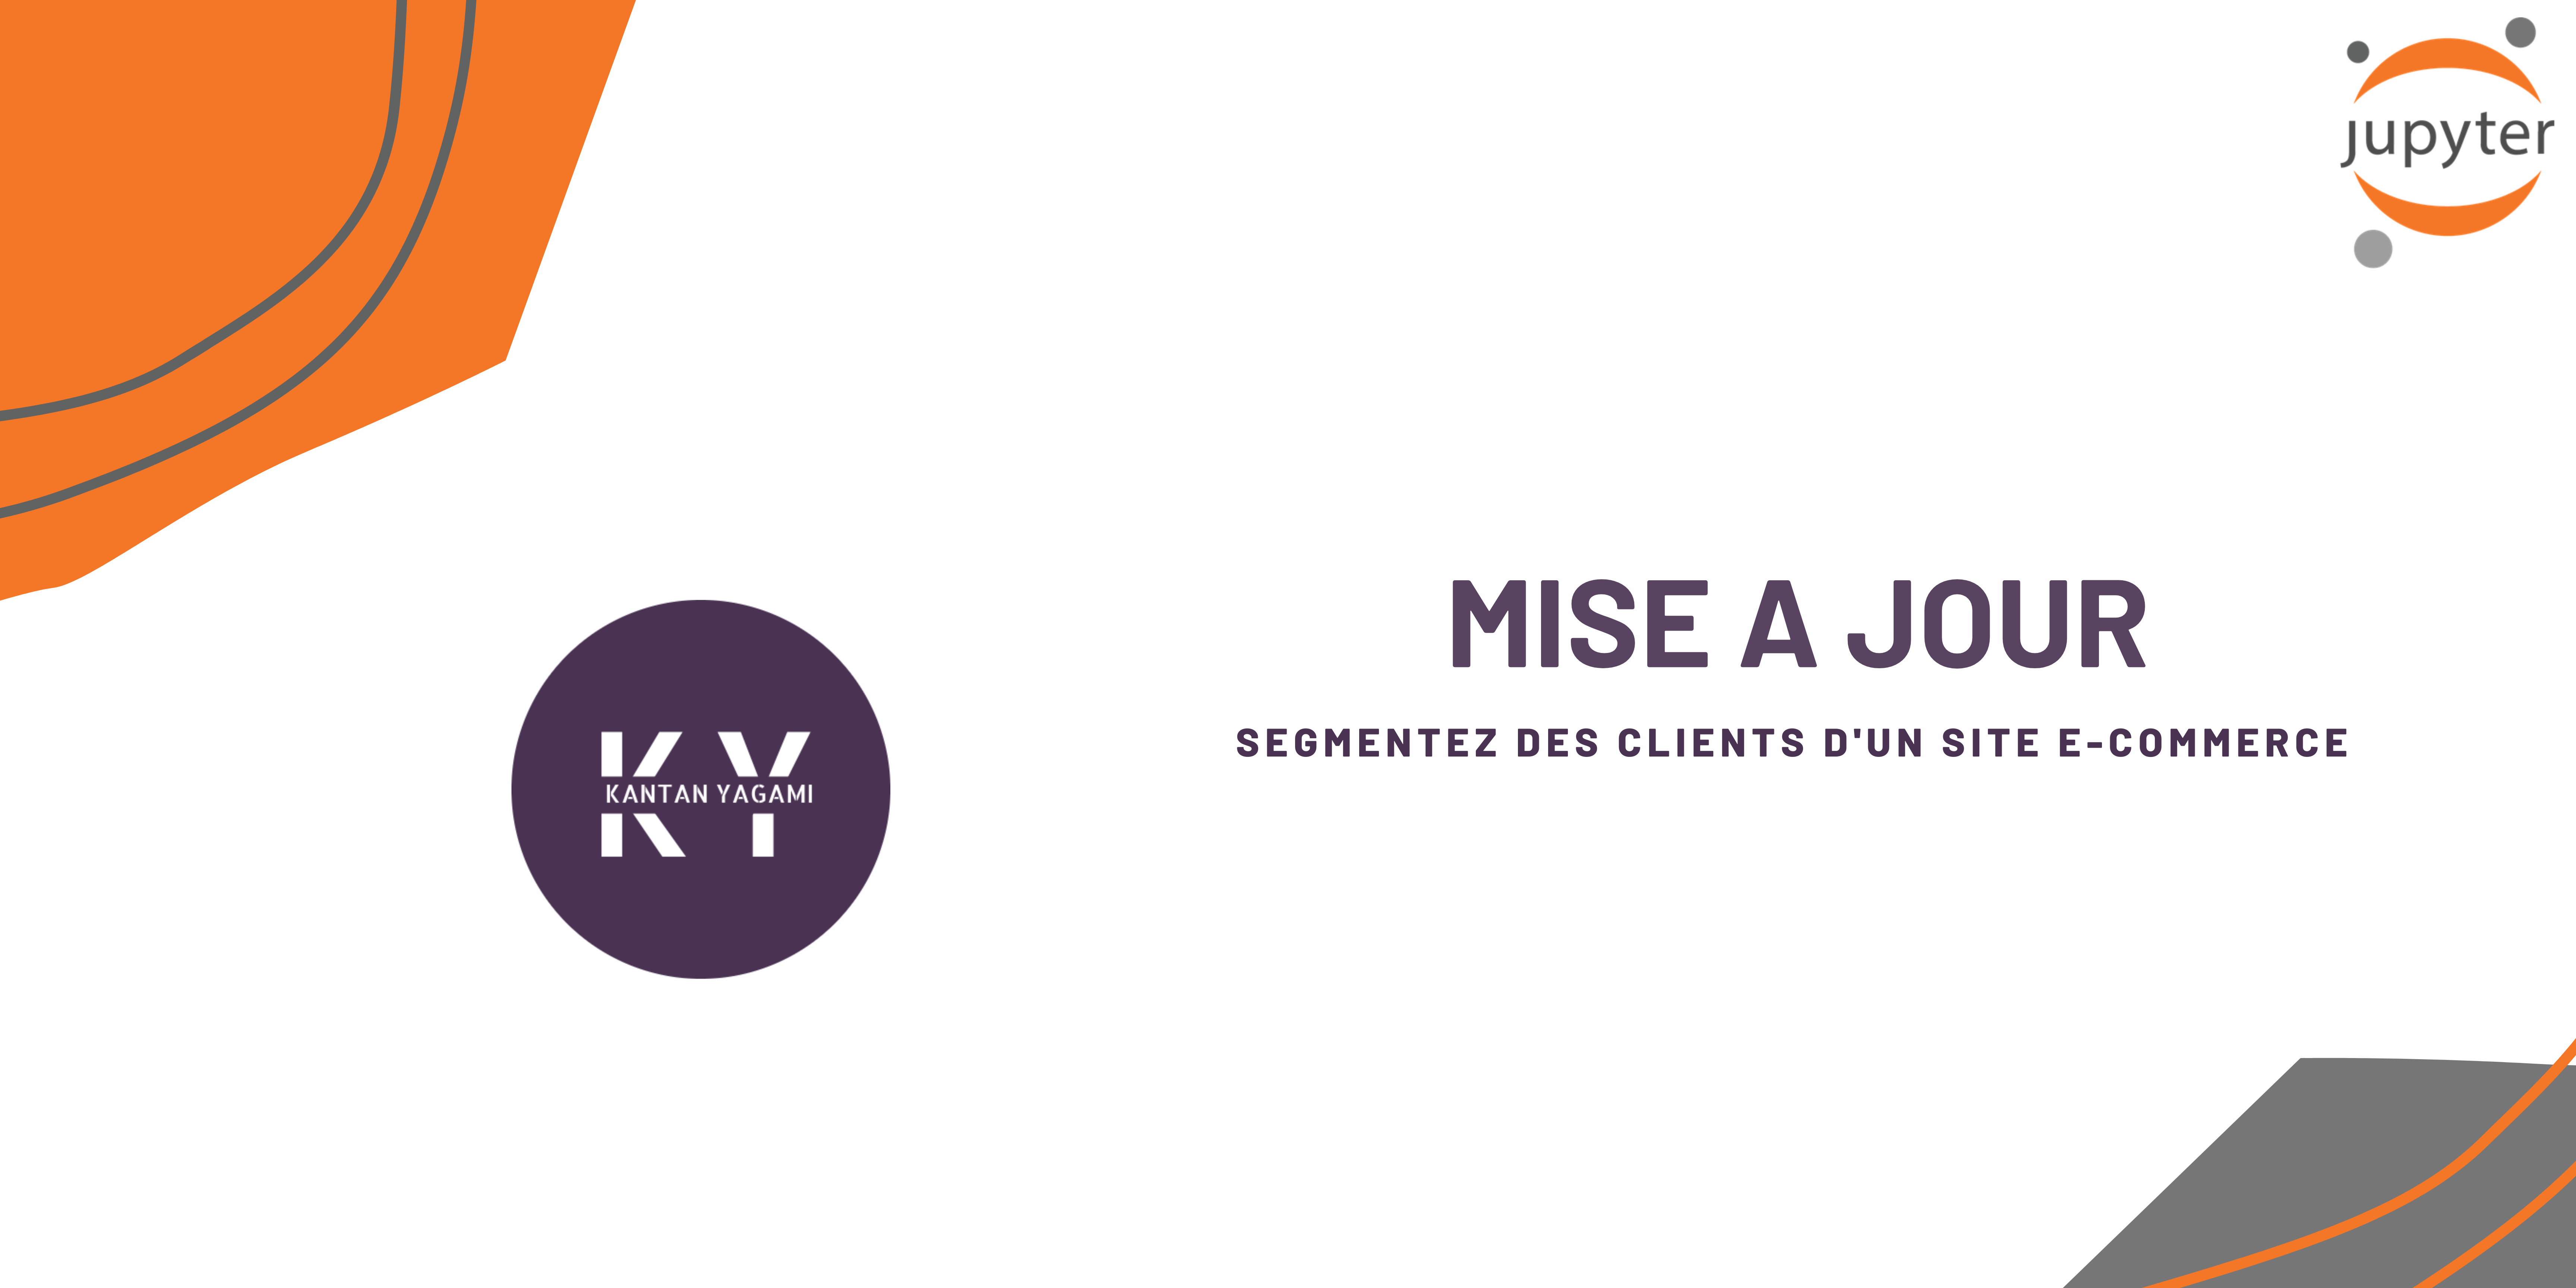

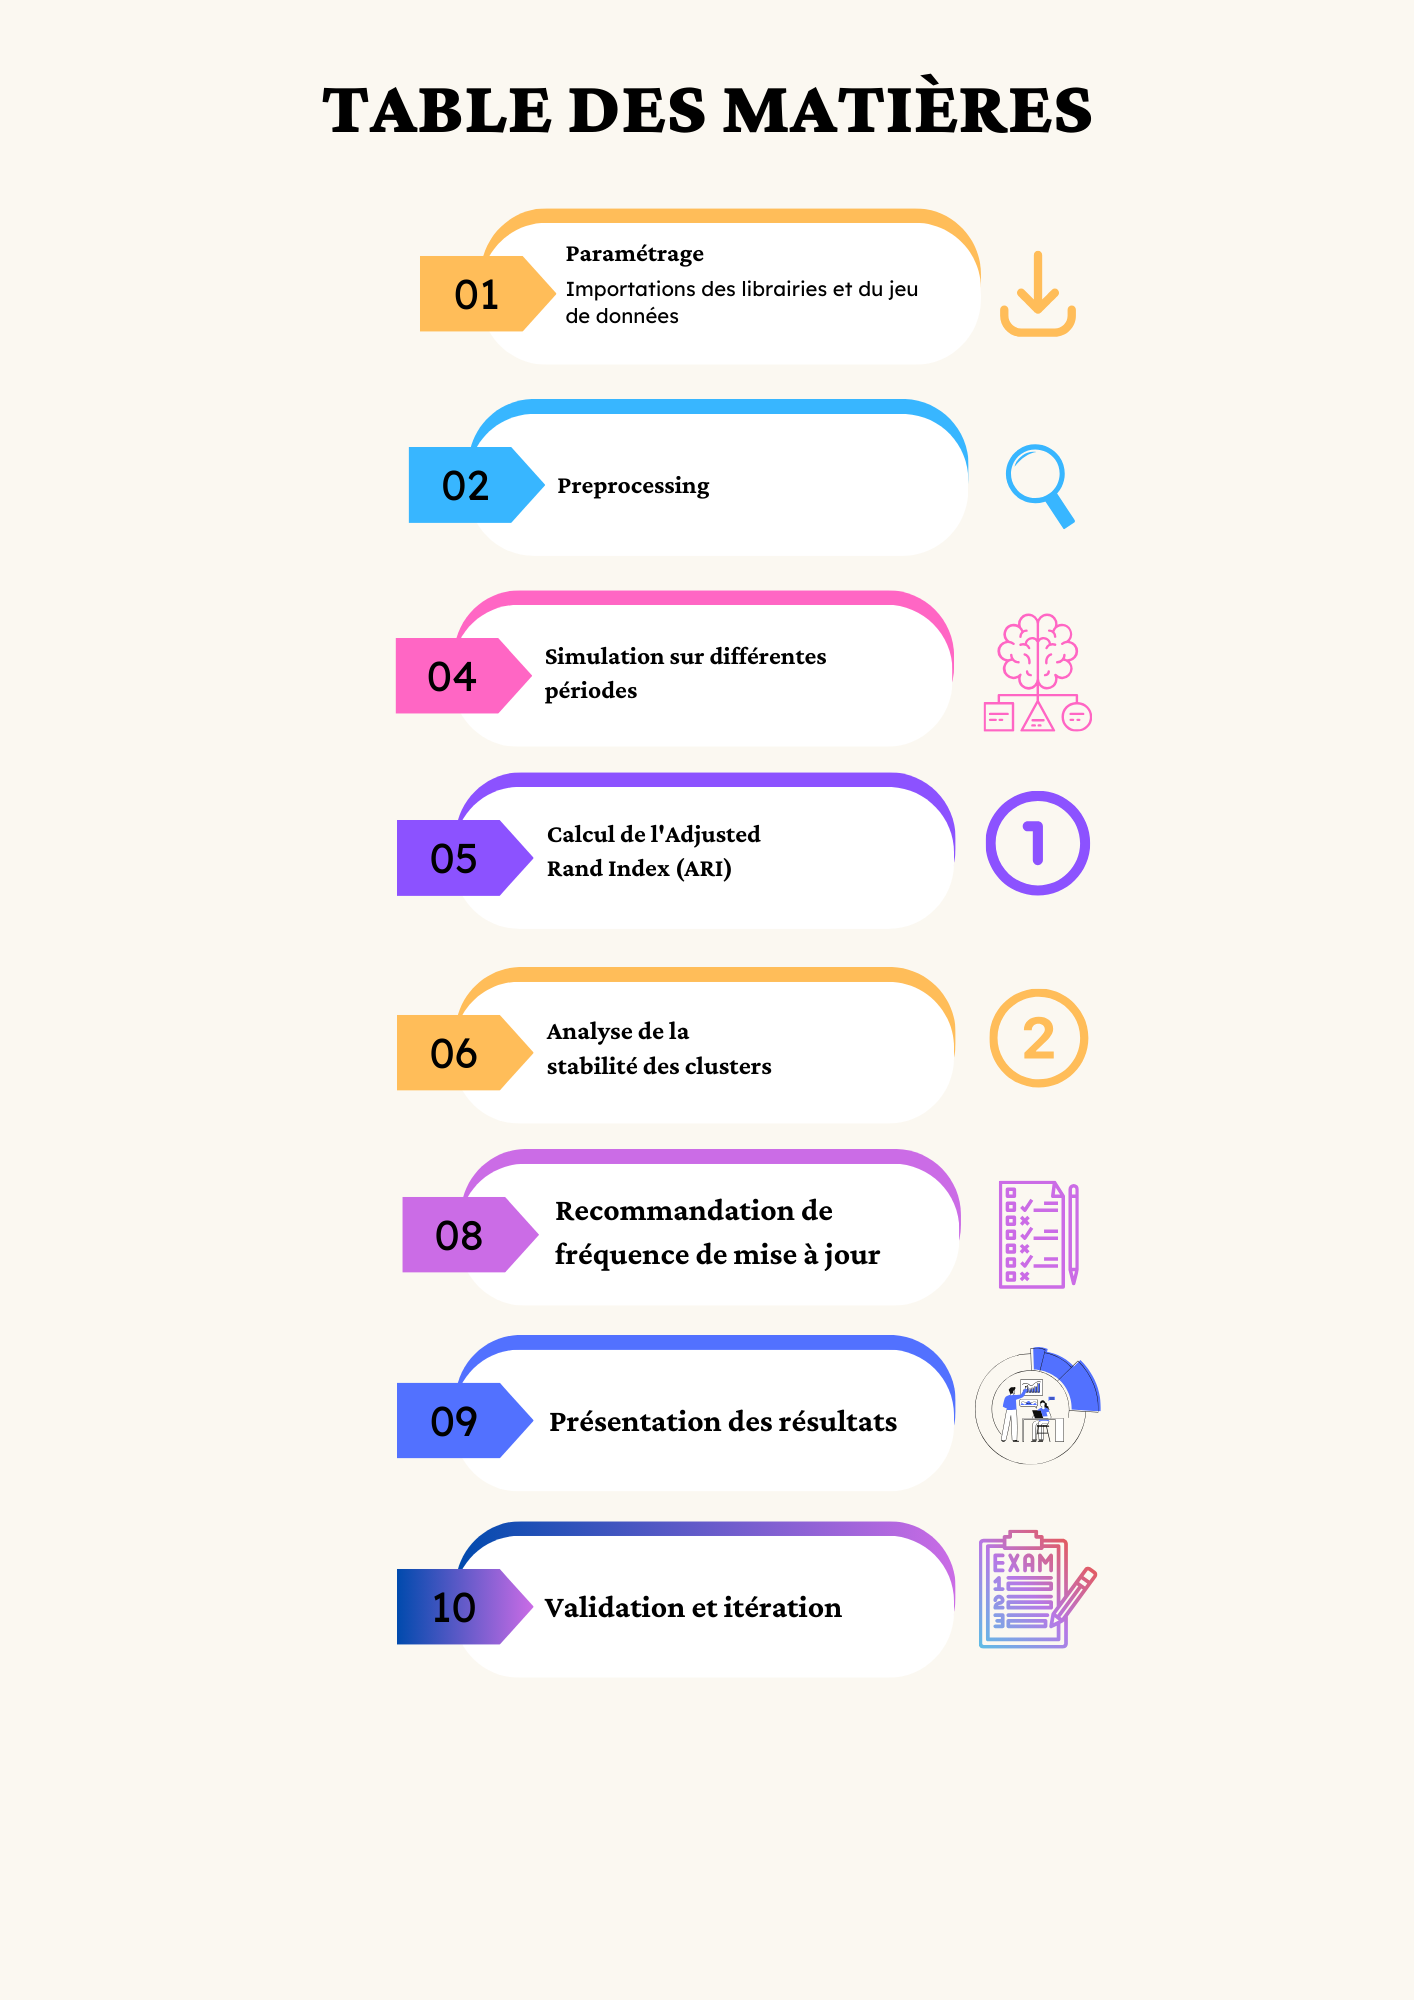

## Paramétrage

### Importations

In [1]:
import sqlite3

import numpy as np
import pandas as pd

from tqdm import tqdm

import time

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from scipy import stats

from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_squared_error

from sklearn.impute import KNNImputer

from sklearn.decomposition import KernelPCA

from sklearn.manifold import Isomap, TSNE, LocallyLinearEmbedding

from kneed import KneeLocator

from tqdm import tqdm

from sklearn.metrics import adjusted_rand_score

## Préprocessing

### Connexion à la base de données

In [2]:
# Chemin vers le fichier de base de données SQLite

db_path = 'Data/DB/olist.db'

# Connexion à la base de données
conn = sqlite3.connect(db_path)

### Requêtes à la base de données

Pour optimiser la fréquence de mise à jour de notre modèle de segmentation client sur le site de e-commerce, nous adoptons une stratégie d'analyse sur des périodes de trois mois, six mois et un an.

Cette approche nous permet d'identifier les tendances d'achat à court et long terme et d'ajuster nos stratégies marketing en conséquence.

En parallèle, nous accordons une attention particulière aux 3% de clients les plus actifs pour cerner les opportunités de fidélisation et peaufiner nos actions de marketing ciblé.

Cette méthode assure une segmentation client à jour, précise et stratégiquement alignée sur les besoins changeants du marché.

**3 Mois :**

- Cela peut capturer les tendances saisonnières ou à court terme.

- Utile pour réagir rapidement aux changements récents dans les comportements ou performances.


**6 Mois :**

- Fournit une vue plus équilibrée qui peut lisser les fluctuations à très court terme tout en capturant les tendances significatives.

- Peut aider à planifier des ajustements stratégiques ou des campagnes marketing.


**Un An :**

- Offre une perspective complète sur les tendances annuelles, y compris toutes les saisons.

- Idéal pour l'analyse de la performance annuelle, la planification stratégique à long terme, et pour comprendre l'impact des initiatives annuelles.

#### Recuperation des clients

Recuperation des clients ayant passe plus d'une commande soit 3.014% de clients

In [3]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()

# Exécution d'une requête SQL pour extraire des informations sur les clients
"""
Cette requête sélectionne le nombre de commandes par client (Orders_number),

ainsi que les identifiants de commande (order_id), l'identifiant client dans la table des commandes (customer_id)
et l'identifiant unique du client (customer_unique_id).

La jointure est faite entre les tables 'orders' et 'customers' sur la base de l'identifiant client.

Les données sont regroupées par l'identifiant unique du client.

La clause 'HAVING' est utilisée pour ne considérer que les clients ayant réalisé plus d'une commande.

"""

cur.execute("""
select count(o.order_id) as 'Orders_number', o.order_id, c.customer_id, c.customer_unique_id
from orders o, customers c
where o.customer_id = c.customer_id
group by c.customer_unique_id
having count(o.order_id) > 1
"""
           )

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'resultats'.
resultats = cur.fetchall()

#### Dernier mois disponible 

**Recency**

In [4]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()

# Exécution d'une requête SQL pour déterminer la date de la dernière commande de chaque client

"""
Cette requête sélectionne deux champs : l'identifiant unique de chaque client (customer_unique_id)
et la date de sa dernière commande (last_purchase_date) pour le dernier mois disponible dans la base de données.
Une jointure est effectuée entre les tables 'customers' et 'orders' en utilisant l'identifiant client.
La fonction MAX() est utilisée pour trouver la commande la plus récente pour chaque client,
en filtrant les commandes basées sur la date du dernier mois par rapport à la date la plus récente trouvée dans les commandes.
Les résultats sont regroupés par l'identifiant unique du client pour s'assurer que chaque client est représenté une seule fois.

"""

cur.execute("""
SELECT customer_unique_id, MAX(order_purchase_timestamp) AS last_purchase_date
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-3 month') FROM orders
    ) AND order_status != 'canceled'
    GROUP BY customer_unique_id;
"""
)

Recency_last_month = cur.fetchall()

**Frequency**

In [5]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer la Frequency pour le dernier mois
"""
 Requête SQL pour calculer la fréquence des commandes par client pour le dernier mois.
Cette requête compte le nombre total de commandes passées par chaque client dans le dernier mois.
Les commandes sont filtrées pour ne prendre en compte que celles réalisées durant le dernier mois par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, COUNT(order_id) AS total_orders
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-3 month') FROM orders
    ) AND order_status != 'canceled'
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Frequency_last_month = cur.fetchall()

**Rising**

In [6]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer le Rising pour le dernier mois
"""
Requête SQL pour calculer le montant total dépensé par chaque client pour le dernier mois.
Cette requête calcule la somme totale des valeurs de paiement pour toutes les commandes passées par chaque client dans le dernier mois.
Les paiements sont filtrés pour ne prendre en compte que ceux réalisés durant le dernier mois par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, SUM(payment_value) AS total_spent
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    JOIN order_pymts ON orders.order_id = order_pymts.order_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-3 month') FROM orders
    ) AND order_status != 'canceled'
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Rising_last_month = cur.fetchall()

***Création des Jeux de Données et feature Engineering pour le dernier mois***

In [7]:
# Convertir les résultats SQL en DataFrames Pandas
df_importance_last_month = pd.DataFrame(resultats, columns=['Orders_number', 'order_id', 'customer_id', 'customer_unique_id'])
df_recency_last_month = pd.DataFrame(Recency_last_month, columns=['customer_unique_id', 'last_purchase_date'])
df_frequency_last_month = pd.DataFrame(Frequency_last_month, columns=['customer_unique_id', 'total_orders'])
df_rising_last_month = pd.DataFrame(Rising_last_month, columns=['customer_unique_id', 'total_spent'])

# Fusionner les DataFrames pour créer un seul DataFrame avec toutes les informations
df_merged_last_month = df_recency_last_month.merge(df_frequency_last_month, on='customer_unique_id', how='outer')
df_merged_last_month = df_merged_last_month.merge(df_rising_last_month, on='customer_unique_id', how='outer')
df_merged_last_month = df_merged_last_month.merge(df_importance_last_month[['customer_unique_id', 'Orders_number']], on='customer_unique_id', how='outer')

# Avant de supprimer 'Orders_number', vous on créer d'abord  la colonne 'Importance'
df_merged_last_month['Importance'] = df_merged_last_month['Orders_number'] > 1

# Ensuite, on supprimer la colonne 'Orders_number'
df_merged_last_month.drop('Orders_number', axis=1, inplace=True)

# Renommer le DataFrame final en df_last_month
df_last_month = df_merged_last_month.copy()
df_last_month.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Rising', 'Importance']

# Afficher le DataFrame final
df_last_month.head()


,customer_unique_id,Recency,Frequency,Rising,Importance
0,000ec5bff359e1c0ad76a81a45cb598f,2018-08-21 11:34:26,1.0,27.75,False
1,000fbf0473c10fc1ab6f8d2d286ce20c,2018-07-26 09:43:52,1.0,362.38,False
2,0015752e079902b12cd00b9b7596276b,2018-08-02 18:23:51,1.0,74.82,False
3,00172711b30d52eea8b313a7f2cced02,2018-07-28 00:23:49,1.0,122.07,True
4,001928b561575b2821c92254a2327d06,2018-08-24 21:17:00,1.0,164.81,False


#### Derniers  six mois disponible 

**Recency**

In [8]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()

# Exécution d'une requête SQL pour déterminer la date de la dernière commande de chaque client

"""
Cette requête sélectionne deux champs : l'identifiant unique de chaque client (customer_unique_id)
et la date de sa dernière commande (last_purchase_date) pour le dernier mois disponible dans la base de données.
Une jointure est effectuée entre les tables 'customers' et 'orders' en utilisant l'identifiant client.
La fonction MAX() est utilisée pour trouver la commande la plus récente pour chaque client,
en filtrant les commandes basées sur la date des derniers six mois par rapport à la date la plus récente trouvée dans les commandes.
Les résultats sont regroupés par l'identifiant unique du client pour s'assurer que chaque client est représenté une seule fois.

"""

cur.execute("""
SELECT customer_unique_id, MAX(order_purchase_timestamp) AS last_purchase_date
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-6 month') FROM orders
    )
    GROUP BY customer_unique_id;
"""
)

Recency_last_six_month = cur.fetchall()

**Frequency**

In [9]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer la Frequency pour le dernier mois
"""
 Requête SQL pour calculer la fréquence des commandes par client pour le dernier mois.
Cette requête compte le nombre total de commandes passées par chaque client dans le dernier mois.
Les commandes sont filtrées pour ne prendre en compte que celles réalisées durant les derniers six mois par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, COUNT(order_id) AS total_orders
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-6 month') FROM orders
    )
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Frequency_last_six_month = cur.fetchall()

**Rising**

In [10]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer le Rising pour le dernier mois
"""
Requête SQL pour calculer le montant total dépensé par chaque client pour le dernier mois.
Cette requête calcule la somme totale des valeurs de paiement pour toutes les commandes passées par chaque client dans le dernier mois.
Les paiements sont filtrés pour ne prendre en compte que ceux réalisés durant les derniers six mois par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, SUM(payment_value) AS total_spent
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    JOIN order_pymts ON orders.order_id = order_pymts.order_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-6 month') FROM orders
    )
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Rising_last_six_month  = cur.fetchall()

**Création des Jeux de Données et feature Engineering pour les six derniers mois**

In [11]:
# Conversion des résultats SQL en DataFrames Pandas
df_importance_last_six_month = pd.DataFrame(resultats, columns=['Orders_number', 'order_id', 'customer_id', 'customer_unique_id'])
df_recency_last_six_month = pd.DataFrame(Recency_last_six_month, columns=['customer_unique_id', 'last_purchase_date'])
df_frequency_last_six_month = pd.DataFrame(Frequency_last_six_month, columns=['customer_unique_id', 'total_orders'])
df_rising_last_six_month = pd.DataFrame(Rising_last_six_month, columns=['customer_unique_id', 'total_spent'])

# Fusionner les DataFrames pour créer un seul DataFrame avec toutes les informations
df_last_six_month = df_recency_last_six_month.merge(df_frequency_last_six_month, on='customer_unique_id', how='outer')
df_last_six_month = df_last_six_month.merge(df_rising_last_six_month, on='customer_unique_id', how='outer')
df_last_six_month = df_last_six_month.merge(df_importance_last_six_month[['customer_unique_id', 'Orders_number']], on='customer_unique_id', how='outer')

# Remplir les valeurs manquantes pour 'Importance' et renommer les colonnes pour clarifier
df_last_six_month['Importance'] = df_last_six_month['Orders_number'] > 1
df_last_six_month.drop('Orders_number', axis=1, inplace=True)
df_last_six_month.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Rising', 'Importance']

# Afficher le DataFrame final
df_last_six_month.head()

,customer_unique_id,Recency,Frequency,Rising,Importance
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1.0,141.90,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1.0,27.19,False
2,00050ab1314c0e55a6ca13cf7181fecf,2018-04-20 12:57:23,1.0,35.38,False
3,000949456b182f53c18b68d6babc79c1,2018-04-23 09:55:46,1.0,82.05,False
4,000e309254ab1fc5ba99dd469d36bdb4,2018-06-25 09:53:57,1.0,78.42,False


#### Dernière année 

**Recency**

In [12]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()

# Exécution d'une requête SQL pour déterminer la date de la dernière commande de chaque client

"""
Cette requête sélectionne deux champs : l'identifiant unique de chaque client (customer_unique_id)
et la date de sa dernière commande (last_purchase_date) pour le dernier mois disponible dans la base de données.
Une jointure est effectuée entre les tables 'customers' et 'orders' en utilisant l'identifiant client.
La fonction MAX() est utilisée pour trouver la commande la plus récente pour chaque client,
en filtrant les commandes basées sur la dernière année par rapport à la date la plus récente trouvée dans les commandes.
Les résultats sont regroupés par l'identifiant unique du client pour s'assurer que chaque client est représenté une seule fois.

"""

cur.execute("""
SELECT customer_unique_id, MAX(order_purchase_timestamp) AS last_purchase_date
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-12 month') FROM orders
    )
    GROUP BY customer_unique_id;
"""
)

Recency_last_year = cur.fetchall()

**Frequency**

In [13]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer la Frequency pour le dernier mois
"""
 Requête SQL pour calculer la fréquence des commandes par client pour le dernier mois.
Cette requête compte le nombre total de commandes passées par chaque client dans le dernier mois.
Les commandes sont filtrées pour ne prendre en compte que celles réalisées durant la dernière année par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, COUNT(order_id) AS total_orders
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-12 month') FROM orders
    )
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Frequency_last_year = cur.fetchall()

**Rising**

In [14]:
# Création d'un objet Cursor pour interagir avec la base de données
cur = conn.cursor()


# Requête pour calculer le Rising pour le dernier mois
"""
Requête SQL pour calculer le montant total dépensé par chaque client pour le dernier mois.
Cette requête calcule la somme totale des valeurs de paiement pour toutes les commandes passées par chaque client dans le dernier mois.
Les paiements sont filtrés pour ne prendre en compte que ceux réalisés durant durant la dernière année par rapport à la date la plus récente trouvée dans la base de données.
Les résultats sont ensuite regroupés par l'identifiant unique du client.

"""

cur.execute("""
    SELECT customer_unique_id, SUM(payment_value) AS total_spent
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    JOIN order_pymts ON orders.order_id = order_pymts.order_id
    WHERE order_purchase_timestamp >= (
        SELECT date(MAX(order_purchase_timestamp), '-12 month') FROM orders
    )
    GROUP BY customer_unique_id;
""")

# Récupération des résultats de la requête
# Les résultats sont stockés dans la variable 'Recency'.
Rising_last_year = cur.fetchall()

**Création des Jeux de Données et feature Engineering pour la dernière année**

In [15]:
# Conversion des résultats SQL en DataFrames Pandas pour la dernière année
df_importance_last_year = pd.DataFrame(resultats, columns=['Orders_number', 'order_id', 'customer_id', 'customer_unique_id'])
df_recency_last_year = pd.DataFrame(Recency_last_year, columns=['customer_unique_id', 'last_purchase_date'])
df_frequency_last_year = pd.DataFrame(Frequency_last_year, columns=['customer_unique_id', 'total_orders'])
df_rising_last_year = pd.DataFrame(Rising_last_year, columns=['customer_unique_id', 'total_spent'])

# Fusionner les DataFrames pour créer un seul DataFrame avec toutes les informations pour la dernière année
df_last_year = df_recency_last_year.merge(df_frequency_last_year, on='customer_unique_id', how='outer')
df_last_year = df_last_year.merge(df_rising_last_year, on='customer_unique_id', how='outer')
df_last_year = df_last_year.merge(df_importance_last_year[['customer_unique_id', 'Orders_number']], on='customer_unique_id', how='outer')

# Remplir les valeurs manquantes pour 'Importance' et renommer les colonnes pour clarifier
df_last_year['Importance'] = df_last_year['Orders_number'] > 1
df_last_year.drop('Orders_number', axis=1, inplace=True)
df_last_year.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Rising', 'Importance']

# Afficher le DataFrame final pour la dernière année
df_last_year.head()

,customer_unique_id,Recency,Frequency,Rising,Importance
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1.0,141.90,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1.0,27.19,False
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1.0,196.89,False
3,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,1.0,166.98,False
4,00050ab1314c0e55a6ca13cf7181fecf,2018-04-20 12:57:23,1.0,35.38,False


### Nettoyage du jeu de données

Valeurs manquantes dans df_last_year:


customer_unique_id    0.000000
Recency               1.105021
Frequency             1.105021
Rising                1.105021
Importance            0.000000
dtype: float64

corrélation entre les valeurs manquantes dans df_last_year:


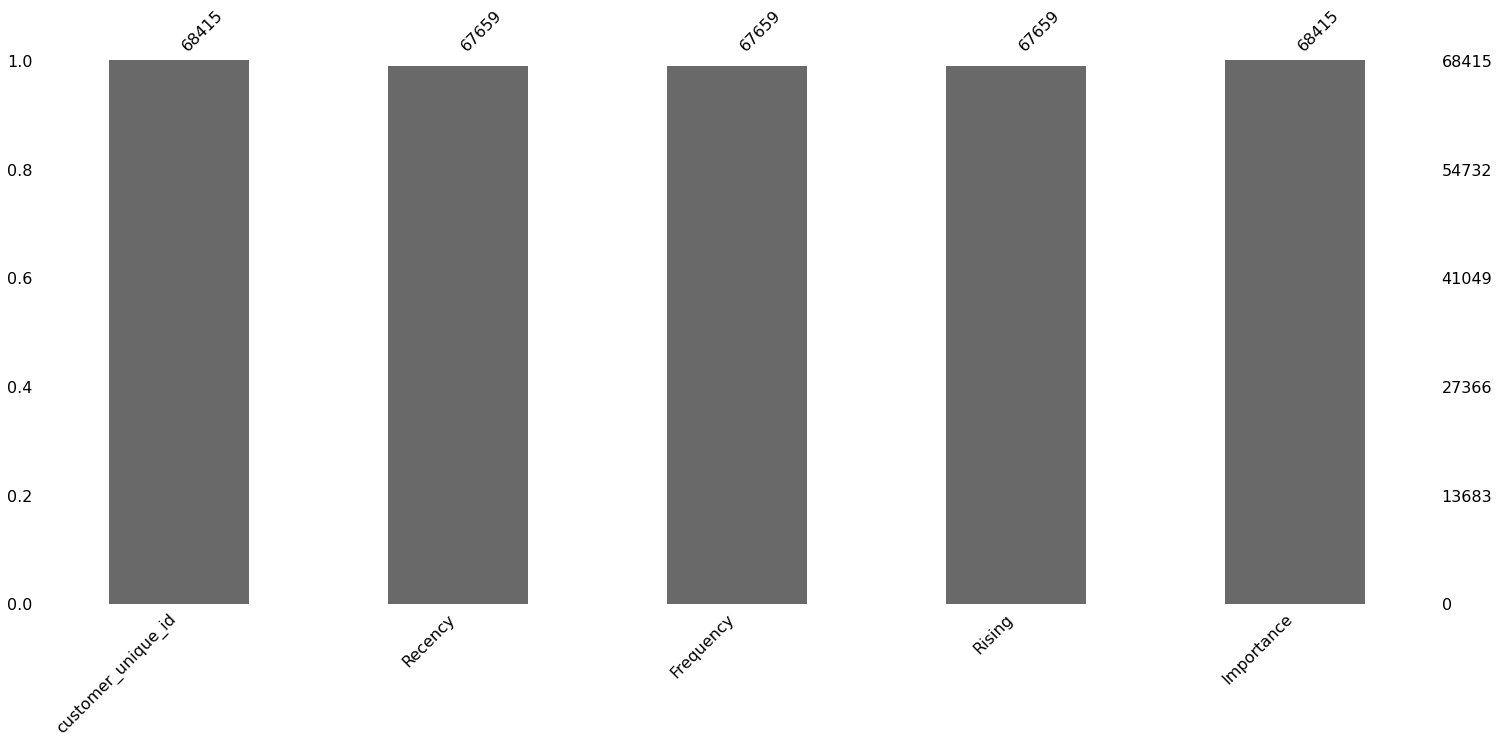

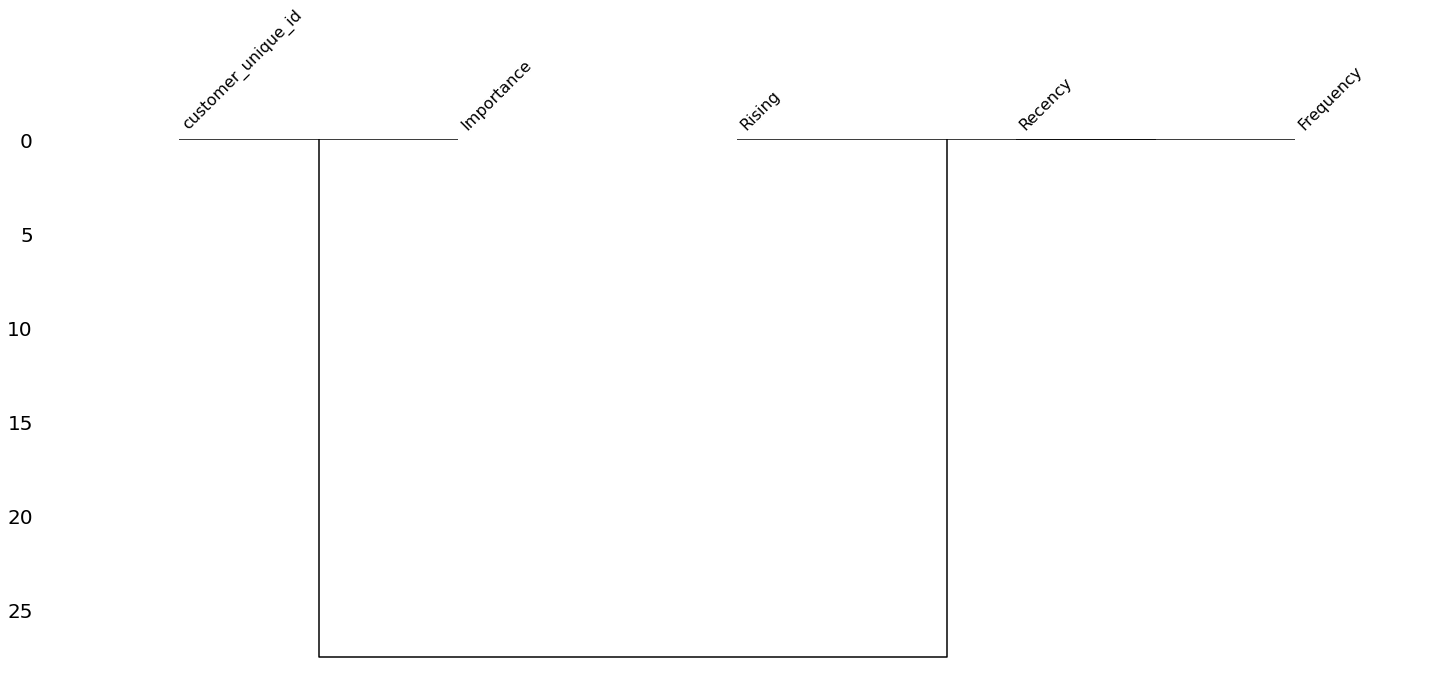

Valeurs manquantes dans df_last_six_month:


customer_unique_id    0.000000
Recency               6.510128
Frequency             6.510128
Rising                6.510128
Importance            0.000000
dtype: float64

corrélation entre les valeurs manquantes dans df_last_six_month:


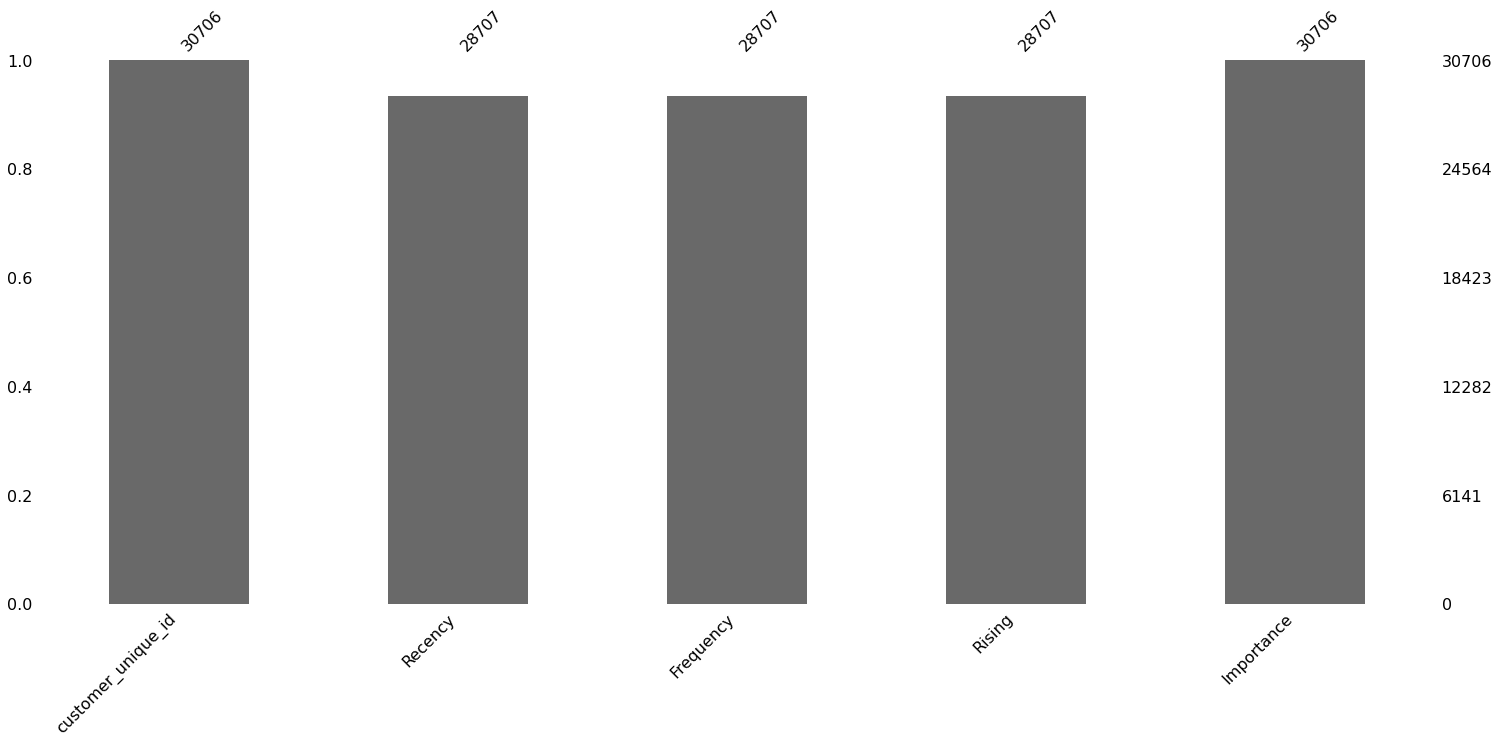

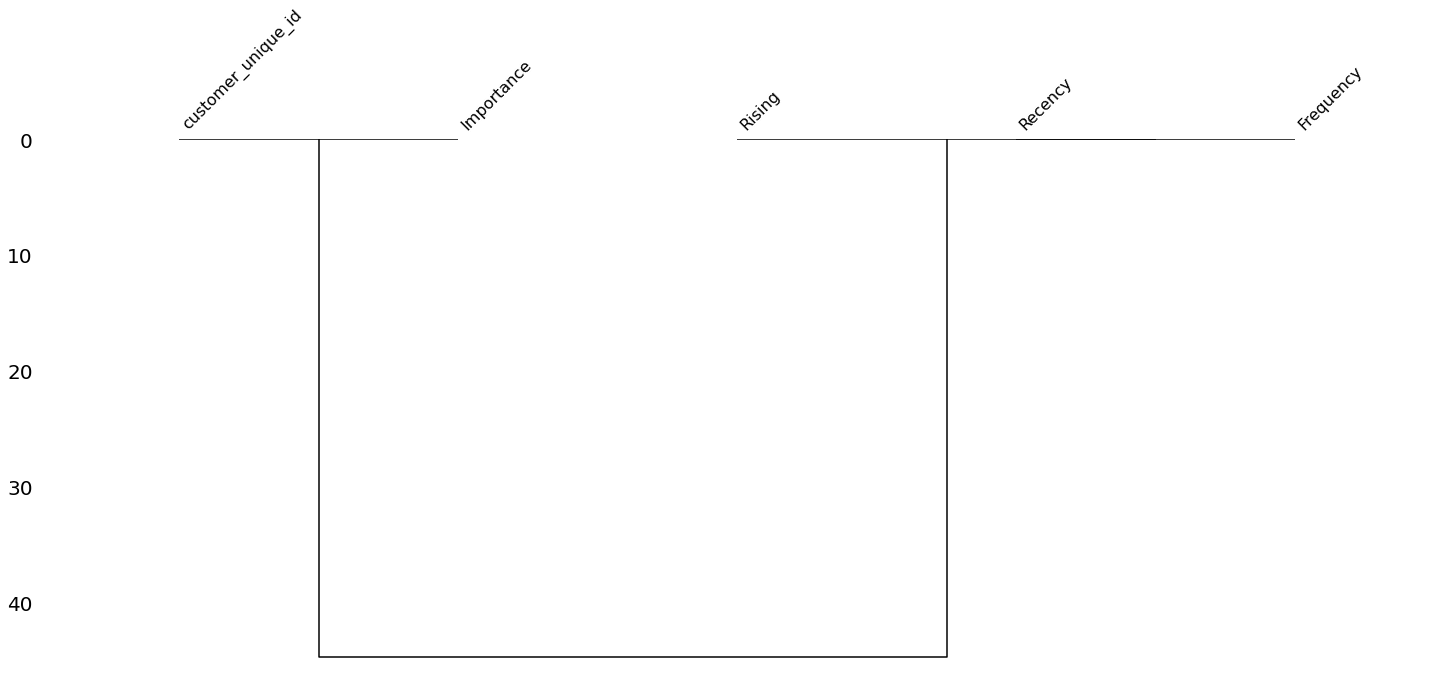

Valeurs manquantes dans df_last_month:


customer_unique_id     0.000000
Recency               20.846209
Frequency             20.846209
Rising                20.846209
Importance             0.000000
dtype: float64

corrélation entre les valeurs manquantes dans df_last_month:


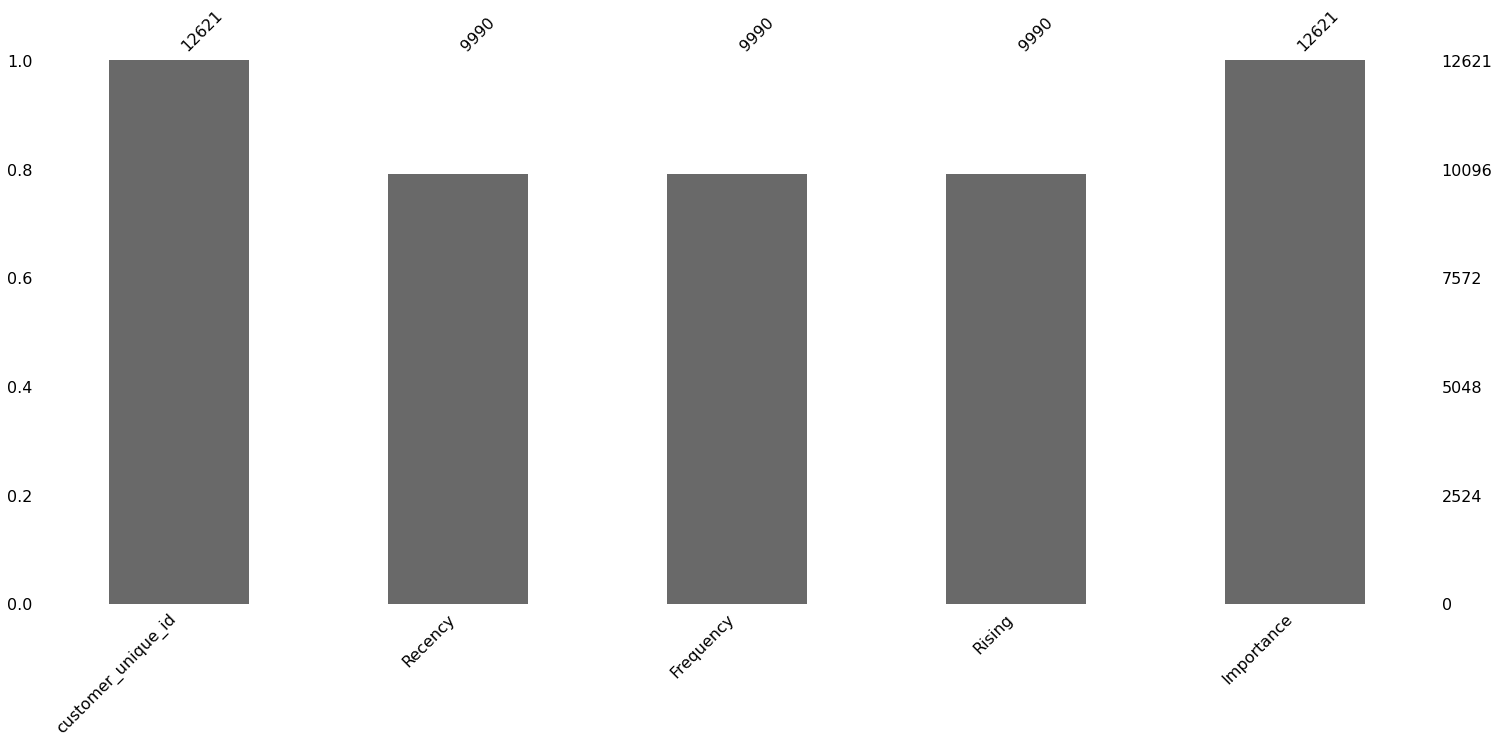

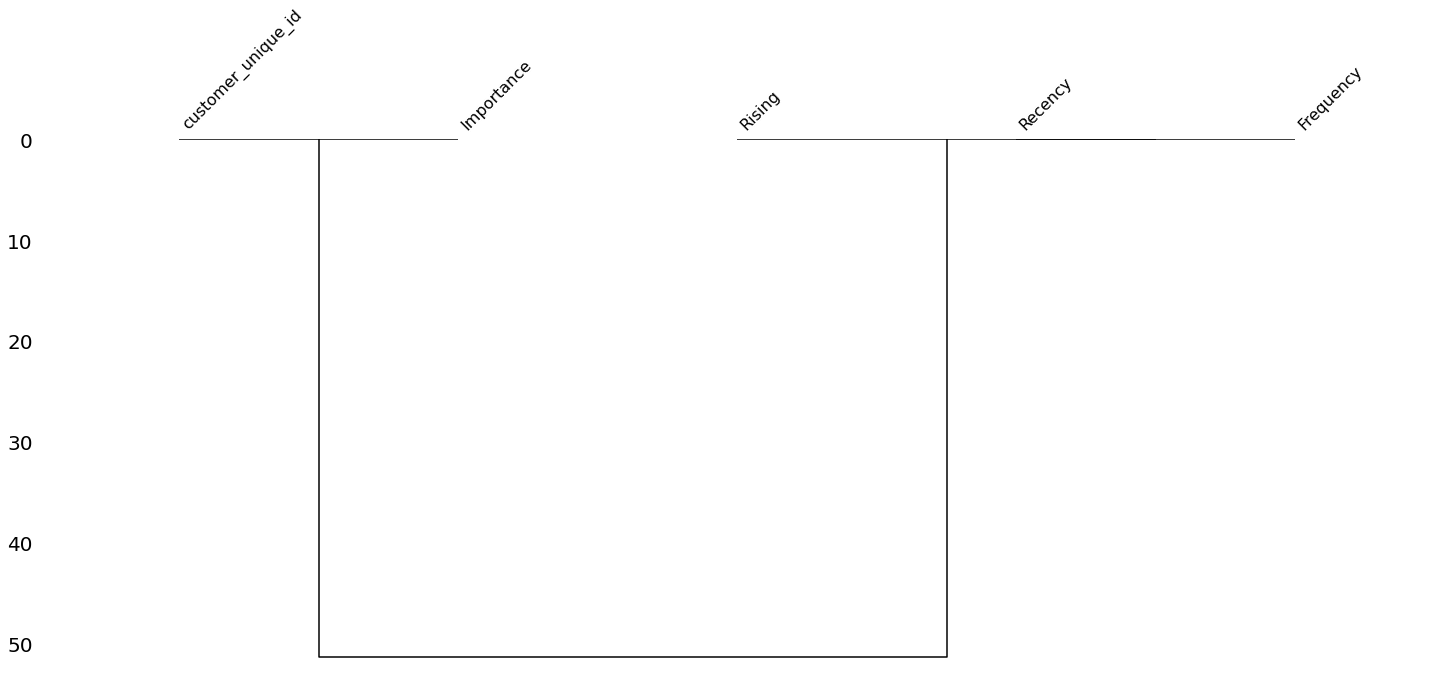

In [16]:
# Liste des noms et des DataFrames pour itération
dataframes_info = [
    ("df_last_year", df_last_year),
    ("df_last_six_month", df_last_six_month),
    ("df_last_month", df_last_month)
]

for df_name, df in dataframes_info:
    print(f"Valeurs manquantes dans {df_name}:")
    display(df.isnull().sum() / len(df) * 100)
    msno.bar(df)
    print(f"corrélation entre les valeurs manquantes dans {df_name}:")
    msno.dendrogram(df)
    plt.show()

L'analyse des dendrogrammes révèle une classification des valeurs manquantes en tant que MNAR (Missing Not At Random). 

Cela signifie que la probabilité qu'une donnée soit manquante dépend des valeurs manquantes elles-mêmes ou de d'autres variables non observées. 

Les tests de normalité peuvent fournir des indices supplémentaires sur la distribution des données et aider à choisir l'approche d'imputation la plus appropriée.

Une distribution normale peut indiquer une prédilection pour des méthodes paramétriques telles que l'imputation par régression, tandis que des distributions non normales pourraient favoriser des méthodes non paramétriques comme KNN ou MissForest.

In [17]:
def convert_recency_to_days(df, date_column):
    # Convertir les chaînes de caractères en dates
    df[date_column] = pd.to_datetime(df[date_column])
    # Trouver la date la plus récente
    most_recent_date = df[date_column].max()
    # Calculer la différence en jours par rapport à cette date la plus récente
    df['Recency'] = (most_recent_date - df[date_column]).dt.days
    return df

# Initialiser DataFrame pour les résultats des tests
results_df = pd.DataFrame(columns=['DataFrame', 'Variable', 'Test', 'Statistique', 'P-Value', 'Normalité'])

# Liste des DataFrames à traiter
dataframes = [df_last_year, df_last_six_month, df_last_month]
dataframe_names = ['Dernière année', 'Derniers six mois', 'Dernier mois']

# Colonnes à utiliser pour l'imputation KNN
columns_with_missing_values = ['Recency', 'Frequency', 'Rising']

# Tester chaque variable quantitative dans chaque DataFrame
variables_to_test = ['Recency', 'Frequency', 'Rising']  # Utiliser 'Recency' au lieu de 'Recency_days'
alpha = 0.05

for df_name, df in zip(dataframe_names, dataframes):
    convert_recency_to_days(df, 'Recency')
    for var in variables_to_test:
        values = df[var].dropna()
        
        # Shapiro-Wilk Test
        shapiro_stat, shapiro_p = stats.shapiro(values)
        results_df = results_df.append({'DataFrame': df_name, 'Variable': var, 'Test': 'Shapiro-Wilk', 
                                        'Statistique': shapiro_stat, 'P-Value': shapiro_p, 
                                        'Normalité': 'Non' if shapiro_p < alpha else 'Oui'}, ignore_index=True)
        
        # Kolmogorov-Smirnov Test
        ks_stat, ks_p = stats.kstest(values, 'norm', args=(values.mean(), values.std()))
        results_df = results_df.append({'DataFrame': df_name, 'Variable': var, 'Test': 'Kolmogorov-Smirnov', 
                                        'Statistique': ks_stat, 'P-Value': ks_p, 
                                        'Normalité': 'Non' if ks_p < alpha else 'Oui'}, ignore_index=True)
        
        # Anderson-Darling Test
        ad_stat, ad_crit_vals, ad_sig_level = stats.anderson(values, dist='norm')
        ad_result = 'Non' if any(ad_stat > crit_val for crit_val, sig_lvl in zip(ad_crit_vals, ad_sig_level) if sig_lvl >= (alpha*100)) else 'Oui'
        results_df = results_df.append({'DataFrame': df_name, 'Variable': var, 'Test': 'Anderson-Darling', 
                                        'Statistique': ad_stat, 'P-Value': 'N/A', 
                                        'Normalité': ad_result}, ignore_index=True)
        
        # D'Agostino and Pearson's Test
        dp_stat, dp_p = stats.normaltest(values)
        results_df = results_df.append({'DataFrame': df_name, 'Variable': var, 'Test': "D'Agostino-Pearson", 
                                        'Statistique': dp_stat, 'P-Value': dp_p, 
                                        'Normalité': 'Non' if dp_p < alpha else 'Oui'}, ignore_index=True)
        
results_df


/home/nexus/venv/lib/python3.6/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,DataFrame,Variable,Test,Statistique,P-Value,Normalité
0,Dernière année,Recency,Shapiro-Wilk,9.563151e-01,0,Non
1,Dernière année,Recency,Kolmogorov-Smirnov,5.927176e-02,4.60529e-207,Non
2,Dernière année,Recency,Anderson-Darling,7.128840e+02,N/A,Non
3,Dernière année,Recency,D'Agostino-Pearson,4.699316e+04,0,Non
4,Dernière année,Frequency,Shapiro-Wilk,1.281449e-01,0,Non
5,Dernière année,Frequency,Kolmogorov-Smirnov,5.339672e-01,0,Non
6,Dernière année,Frequency,Anderson-Darling,2.506508e+04,N/A,Non
7,Dernière année,Frequency,D'Agostino-Pearson,1.082729e+05,0,Non
8,Dernière année,Rising,Shapiro-Wilk,4.917176e-01,0,Non
9,Dernière année,Rising,Kolmogorov-Smirnov,2.524639e-01,0,Non


Les résultats des tests de normalité indiquent clairement que les variables `Recency`, `Frequency`, et `Rising` de nos trois séries temporelles ne suivent pas une distribution normale.

Cette observation nous oriente vers l'utilisation de méthodes d'imputation adaptées à des données non normales. Nous avons choisi l'imputation par KNN pour traiter les valeurs manquantes, principalement en raison de sa simplicité et de sa capacité à gérer efficacement ce type de données, contrairement à l'imputation par régression qui suppose une distribution normale des données.

MissForest, bien que performant, est écarté ici en raison de sa complexité et de sa lourdeur computationnelle pour notre contexte d'application.

In [18]:
# Liste des DataFrames à traiter
dataframes = [df_last_year, df_last_six_month, df_last_month]
dataframe_names = ['Dernière année', 'Derniers six mois', 'Dernier mois']

# Colonnes à utiliser pour l'imputation KNN
columns_with_missing_values = ['Recency', 'Frequency', 'Rising']

# Tester différents nombres de voisins pour chaque DataFrame
for df_name, df in zip(dataframe_names, dataframes):
    print(f"Traitement pour {df_name}:")
    
    # Conversion des colonnes en flottants
    df[columns_with_missing_values] = df[columns_with_missing_values].astype(float)
    
    # Supprimer les lignes avec des valeurs non numériques
    df = df.dropna(subset=columns_with_missing_values)

    # Sélectionner un sous-ensemble de données sans valeurs manquantes
    subset = df[columns_with_missing_values]

    # Tester différents nombres de voisins
    n_neighbors_options = [3, 5, 7, 9, 11]
    results = []

    for n_neighbors in n_neighbors_options:
        imputer = KNNImputer(n_neighbors=n_neighbors)
        imputed_values = imputer.fit_transform(subset)
        mse = mean_squared_error(subset, imputed_values)
        results.append({'n_neighbors': n_neighbors, 'MSE': mse})

    # Convertir les résultats en DataFrame
    results_df = pd.DataFrame(results)

    # Afficher les résultats
    print(results_df)

    # Choisir le nombre de voisins avec l'erreur la plus faible
    best_n_neighbors = results_df.loc[results_df['MSE'].idxmin(), 'n_neighbors']
    print(f"Meilleur nombre de voisins pour {df_name}: {best_n_neighbors}\n")


Traitement pour Dernière année:
   n_neighbors  MSE
0            3  0.0
1            5  0.0
2            7  0.0
3            9  0.0
4           11  0.0
Meilleur nombre de voisins pour Dernière année: 3

Traitement pour Derniers six mois:
   n_neighbors  MSE
0            3  0.0
1            5  0.0
2            7  0.0
3            9  0.0
4           11  0.0
Meilleur nombre de voisins pour Derniers six mois: 3

Traitement pour Dernier mois:
   n_neighbors  MSE
0            3  0.0
1            5  0.0
2            7  0.0
3            9  0.0
4           11  0.0
Meilleur nombre de voisins pour Dernier mois: 3



In [19]:
# Créer l'objet KNNImputer avec 3 voisins
imputer = KNNImputer(n_neighbors=3)

# Mesurer le temps de début
start_time = time.time()

# Appliquer l'imputation sur les colonnes 'Recency', 'Frequency', 'Rising' de chaque DataFrame
for df in [df_last_year, df_last_six_month, df_last_month]:
    df[['Recency', 'Frequency', 'Rising']] = imputer.fit_transform(df[['Recency', 'Frequency', 'Rising']])

# Mesurer le temps de fin
end_time = time.time()

# Calculer le temps total
time_taken = end_time - start_time
print(f"Temps d'exécution de l'imputation : {time_taken} secondes")

# Afficher les premières lignes pour vérifier l'imputation
for df_name, df in zip(dataframe_names, dataframes):
    print(f"\nDataFrame : {df_name}")
    print(df.head())

Temps d'exécution de l'imputation : 21.42449688911438 secondes

DataFrame : Dernière année
                 customer_unique_id  Recency  Frequency  Rising  Importance
0  0000366f3b9a7992bf8c76cfdf3221e2    160.0        1.0  141.90       False
1  0000b849f77a49e4a4ce2b2a4ca5be3f    163.0        1.0   27.19       False
2  0004aac84e0df4da2b147fca70cf8255    336.0        1.0  196.89       False
3  0004bd2a26a76fe21f786e4fbd80607f    194.0        1.0  166.98       False
4  00050ab1314c0e55a6ca13cf7181fecf    180.0        1.0   35.38       False

DataFrame : Derniers six mois
                 customer_unique_id  Recency  Frequency  Rising  Importance
0  0000366f3b9a7992bf8c76cfdf3221e2    160.0        1.0  141.90       False
1  0000b849f77a49e4a4ce2b2a4ca5be3f    163.0        1.0   27.19       False
2  00050ab1314c0e55a6ca13cf7181fecf    180.0        1.0   35.38       False
3  000949456b182f53c18b68d6babc79c1    177.0        1.0   82.05       False
4  000e309254ab1fc5ba99dd469d36bdb4    114

In [20]:
# Liste des noms et des DataFrames pour itération
dataframes_info = [
    ("df_last_year", df_last_year),
    ("df_last_six_month", df_last_six_month),
    ("df_last_month", df_last_month)
]

for df_name, df in dataframes_info:
    print(f"Valeurs manquantes dans {df_name}:")
    display(df.isnull().sum() / len(df) * 100)

Valeurs manquantes dans df_last_year:


customer_unique_id    0.0
Recency               0.0
Frequency             0.0
Rising                0.0
Importance            0.0
dtype: float64

Valeurs manquantes dans df_last_six_month:


customer_unique_id    0.0
Recency               0.0
Frequency             0.0
Rising                0.0
Importance            0.0
dtype: float64

Valeurs manquantes dans df_last_month:


customer_unique_id    0.0
Recency               0.0
Frequency             0.0
Rising                0.0
Importance            0.0
dtype: float64

### Normalisation

#### Application de la normalisation

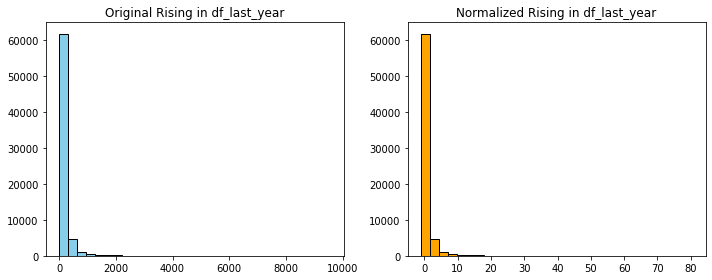

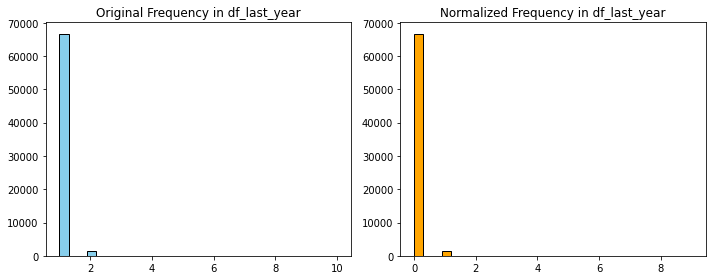

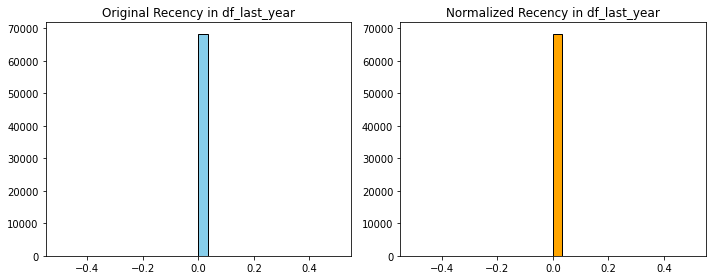

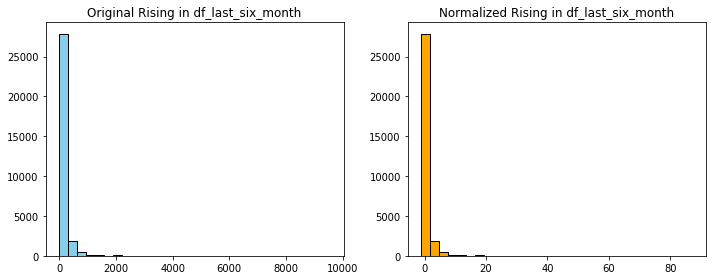

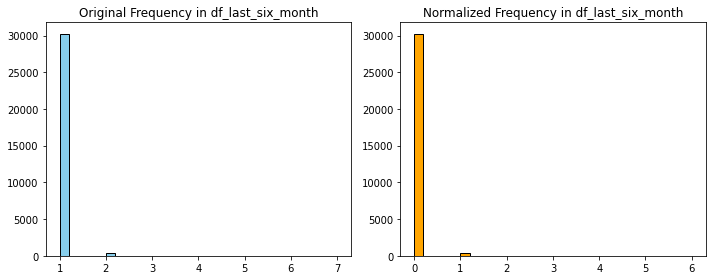

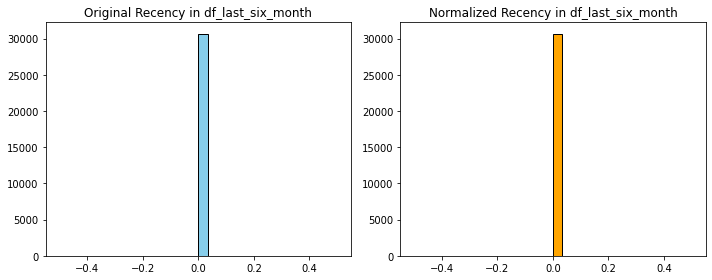

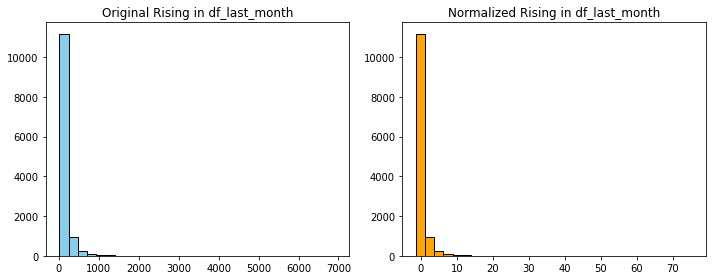

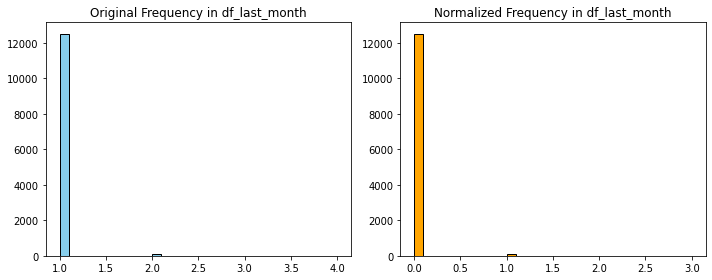

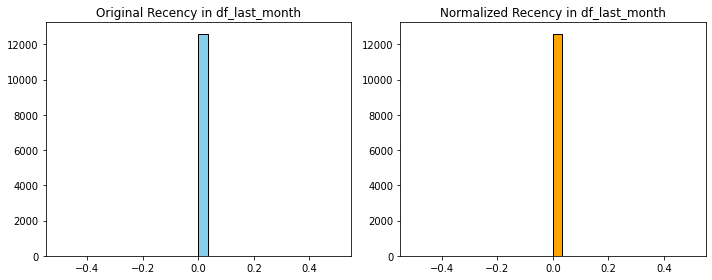

In [21]:
# Initialisation du RobustScaler
scaler = RobustScaler()

# Liste des noms des dataframes pour itération
dataframe_names = ['df_last_year', 'df_last_six_month', 'df_last_month']
dataframes = [df_last_year, df_last_six_month, df_last_month]

# Colonnes à normaliser
columns_to_scale = ['Rising', 'Frequency', 'Recency']

for df_name, df in zip(dataframe_names, dataframes):
    # Convertir 'Recency' en jours
    df = convert_recency_to_days(df, 'Recency')
    
    # Copie des données originales pour la visualisation
    original_data = df[columns_to_scale].copy()

    # Application du RobustScaler
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    # Affichage des distributions avant et après normalisation pour chaque colonne
    for column in columns_to_scale:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.hist(original_data[column].dropna(), bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Original {column} in {df_name}')

        plt.subplot(1, 2, 2)
        plt.hist(df[column].dropna(), bins=30, color='orange', edgecolor='black')
        plt.title(f'Normalized {column} in {df_name}')

        plt.tight_layout()
        plt.show()

### Échantillonnage des données

In [22]:
# Initialiser un dictionnaire pour stocker les échantillons
samples = {}

# Liste des noms des dataframes pour itération
dataframe_names = ['df_last_year', 'df_last_six_month', 'df_last_month']
dataframes = [df_last_year, df_last_six_month, df_last_month]

# Échantillonnage aléatoire sans stratification qui contient 20% des données pour chaque DataFrame
for df_name, df in zip(dataframe_names, dataframes):
    sample, _ = train_test_split(df, test_size=0.8, random_state=42)
    samples[df_name] = sample

### Encoding des variables catégorielles

In [23]:
# Initialisation de OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Liste des noms des DataFrames échantillonnés pour itération
sample_names = ['df_last_year_sample', 'df_last_six_month_sample', 'df_last_month_sample']

# Dictionnaire des DataFrames échantillonnés pour itération
samples = {
    'df_last_year_sample': samples['df_last_year'],
    'df_last_six_month_sample': samples['df_last_six_month'],
    'df_last_month_sample': samples['df_last_month']
}

# Parcourir et transformer chaque DataFrame échantillonné
for sample_name, sample_df in samples.items():
    # Convertir la colonne 'Importance' en type de données catégorielles
    sample_df['Importance'] = sample_df['Importance'].astype('category')

    # Reshape nécessaire car fit_transform attend un 2D array
    importance_encoded = encoder.fit_transform(sample_df[['Importance']])
    columns_names = encoder.get_feature_names(['Importance'])

    # Remplacer la colonne 'Importance' par les colonnes encodées
    samples[sample_name] = pd.concat([sample_df.drop(columns=['Importance']), pd.DataFrame(importance_encoded, index=sample_df.index, columns=columns_names)], axis=1)

# Afficher le résultat pour un des échantillons
print("Exemple avec df_last_year_sample:")
print(samples['df_last_year_sample'].head())

Exemple avec df_last_year_sample:
                     customer_unique_id  Recency  Frequency    Rising  \
46622  aff69511dbf4e69a3d4f0cf0f46cd575      0.0        0.0 -0.668767   
12239  2e40ccac66c1ee178735409e006d17ec      0.0        0.0 -0.273587   
67504  ff60aefe219c1960b74d47d0fc553fc1      0.0        0.0  0.016775   
22082  53aefda7ff8c61644d09043810bbf79f      0.0        0.0  0.943205   
16705  3f04877b0a3842c23e36f422abe4393b      0.0        0.0 -0.238334   

       Importance_False  Importance_True  
46622               1.0              0.0  
12239               1.0              0.0  
67504               1.0              0.0  
22082               1.0              0.0  
16705               1.0              0.0  


/home/nexus/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nexus/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nexus/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

### Réduction dimensionnelle

In [24]:
# Initialisation de KernelPCA
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15, random_state=42)

# Dictionnaire pour stocker les DataFrames réduits
reduced_samples = {}

# Itération sur chaque DataFrame échantillonné dans le dictionnaire 'samples'
for sample_name, sample_df in samples.items():
    # Sélection des colonnes numériques pour la réduction de dimension
    data_numerique = sample_df[['Rising', 'Frequency', 'Recency']]
    
    # Application de la réduction dimensionnelle avec Kernel PCA
    X_reduced = kpca.fit_transform(data_numerique)
    
    # Création d'un DataFrame pour les données réduites
    reduced_df = pd.DataFrame(X_reduced, columns=['KernelPCA1', 'KernelPCA2'], index=sample_df.index)
    
    # Ajout du DataFrame réduit au dictionnaire
    reduced_samples[sample_name + "_reduced"] = reduced_df

# Afficher les premières lignes du DataFrame réduit pour 'df_last_year_sample'
reduced_samples['df_last_year_sample_reduced'].head()

,KernelPCA1,KernelPCA2
46622,0.483806,-0.432195
12239,0.306444,0.561749
67504,-0.441593,0.508637
22082,-0.208941,-0.281713
16705,0.203155,0.634214


### Simulation sur différentes périodes

Score de silhouette pour K-Means avec 3 clusters pour df_last_year_sample_reduced: 0.59


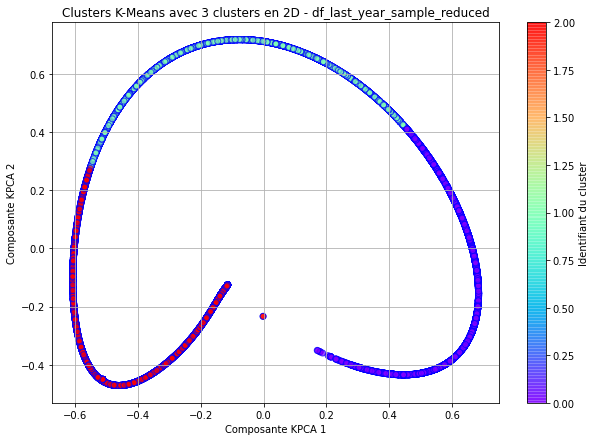

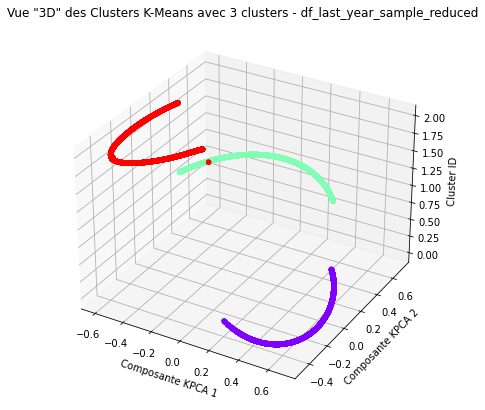

Score de silhouette pour K-Means avec 3 clusters pour df_last_six_month_sample_reduced: 0.58


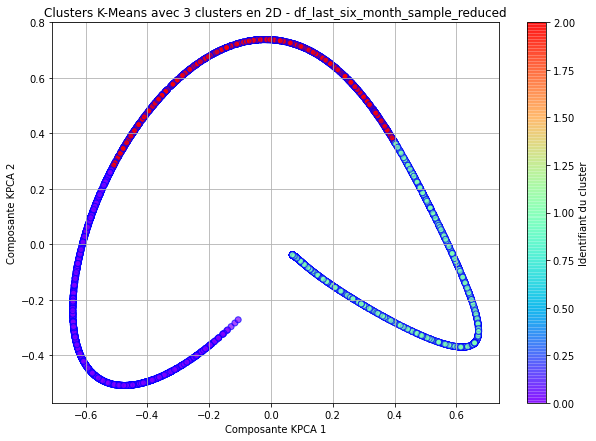

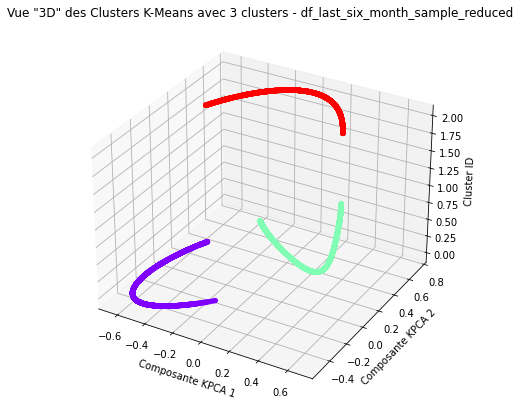

Score de silhouette pour K-Means avec 3 clusters pour df_last_month_sample_reduced: 0.66


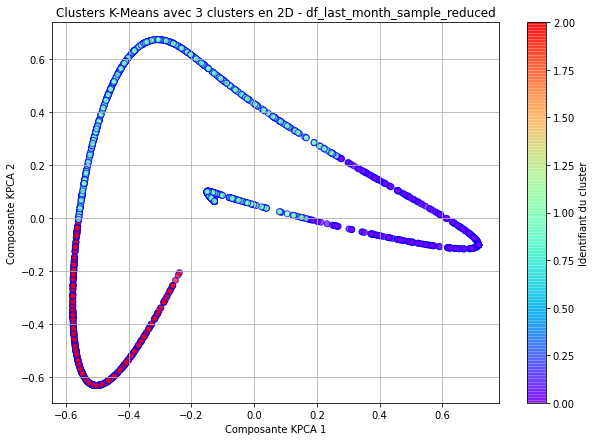

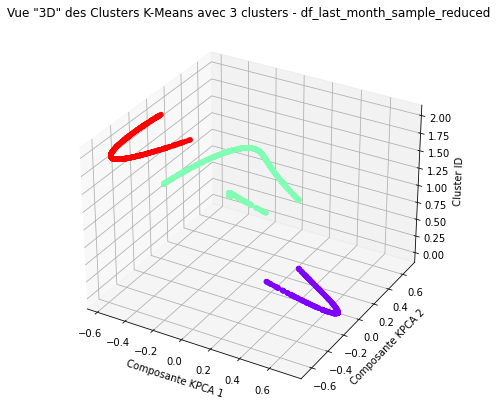

In [25]:
# Initialisation du modèle K-Means
kmeans = KMeans(n_clusters=3, random_state=42)

# Boucle sur chaque DataFrame de série temporelle
for df_name, reduced_df in reduced_samples.items():
    # Appliquer le clustering K-Means
    kmeans_labels = kmeans.fit_predict(reduced_df)
    samples[df_name.replace('_reduced', '')]['Cluster_KMeans'] = kmeans_labels
    
    # Calcul du score de silhouette
    silhouette_avg = silhouette_score(reduced_df, kmeans_labels)
    print(f'Score de silhouette pour K-Means avec 3 clusters pour {df_name}: {silhouette_avg:.2f}')
    
    # Visualisation 2D
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_df.iloc[:, 0], reduced_df.iloc[:, 1], c=kmeans_labels, cmap='rainbow', alpha=0.7, edgecolors='b')
    plt.title(f'Clusters K-Means avec 3 clusters en 2D - {df_name}')
    plt.xlabel('Composante KPCA 1')
    plt.ylabel('Composante KPCA 2')
    plt.colorbar(label='Identifiant du cluster')
    plt.grid(True)
    plt.show()
    
    # Création d'un scatter plot "3D"
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reduced_df.iloc[:, 0], reduced_df.iloc[:, 1], kmeans_labels, c=kmeans_labels, cmap='rainbow', depthshade=False)
    ax.set_title(f'Vue "3D" des Clusters K-Means avec 3 clusters - {df_name}')
    ax.set_xlabel('Composante KPCA 1')
    ax.set_ylabel('Composante KPCA 2')
    ax.set_zlabel('Cluster ID')
    plt.show()

### Calcul de l'ajusted rank index

In [26]:
# Identifier les clients communs à toutes les périodes dans les échantillons
common_customers_samples = set(samples['df_last_year_sample']['customer_unique_id']) & set(samples['df_last_six_month_sample']['customer_unique_id']) & set(samples['df_last_month_sample']['customer_unique_id'])

# Filtrer chaque échantillon réduit pour inclure uniquement les clients communs
df_last_month_reduced_common = reduced_samples['df_last_month_sample_reduced'][reduced_samples['df_last_month_sample_reduced'].index.isin(common_customers_samples)]
df_last_six_month_reduced_common = reduced_samples['df_last_six_month_sample_reduced'][reduced_samples['df_last_six_month_sample_reduced'].index.isin(common_customers_samples)]
df_last_year_reduced_common = reduced_samples['df_last_year_sample_reduced'][reduced_samples['df_last_year_sample_reduced'].index.isin(common_customers_samples)]

# S'assurer que les labels des clusters sont accessibles dans les échantillons communs filtrés
# Les labels des clusters sont déjà dans les DataFrames originaux des échantillons, nous devons juste les récupérer pour les clients communs
labels_last_month_common = samples['df_last_month_sample'][samples['df_last_month_sample']['customer_unique_id'].isin(common_customers_samples)]['Cluster_KMeans']
labels_last_six_month_common = samples['df_last_six_month_sample'][samples['df_last_six_month_sample']['customer_unique_id'].isin(common_customers_samples)]['Cluster_KMeans']
labels_last_year_common = samples['df_last_year_sample'][samples['df_last_year_sample']['customer_unique_id'].isin(common_customers_samples)]['Cluster_KMeans']

# Calculer l'ARI entre les différentes périodes en utilisant les labels des clusters
ari_last_month_six_month = adjusted_rand_score(labels_last_month_common, labels_last_six_month_common)
ari_last_month_year = adjusted_rand_score(labels_last_month_common, labels_last_year_common)
ari_last_six_month_year = adjusted_rand_score(labels_last_six_month_common, labels_last_year_common)

# Afficher les résultats de l'ARI
print(f"ARI entre le dernier mois et les six derniers mois: {ari_last_month_six_month}")
print(f"ARI entre le dernier mois et l'année dernière: {ari_last_month_year}")
print(f"ARI entre les six derniers mois et l'année dernière: {ari_last_six_month_year}")

ARI entre le dernier mois et les six derniers mois: 0.012827942779790618
ARI entre le dernier mois et l'année dernière: -0.019316097283613005
ARI entre les six derniers mois et l'année dernière: -0.001969560502945367


### Analyse de la stabilité des clusters

L'analyse des clusters sur trois périodes distinctes

- les trois derniers mois
- les six derniers mois
- la dernière année

a révélé une faible stabilité dans la segmentation des clients d'Olist, comme en témoignent les valeurs de l'Adjusted Rand Index (ARI) proches de zéro ou négatives.

Cette variabilité suggère que les comportements d'achat des clients d'Olist évoluent significativement sur ces périodes, probablement influencés par des facteurs saisonniers, des tendances de marché, ou des événements spécifiques.

### Recommandation sur la frequance de mises à jour

Face à l'instabilité des clusters, il est essentiel d'adopter une approche proactive pour la mise à jour des clusters.

Une actualisation trimestrielle du modèle de segmentation est recommandée.

Cette fréquence permettra de saisir efficacement les changements dans les comportements des clients tout en évitant la surcharge opérationnelle liée à des mises à jour trop fréquentes.

Une telle approche garantira que la segmentation demeure pertinente et utile pour l'équipe marketing, leur permettant de cibler les clients de manière plus précise et de concevoir des stratégies promotionnelles adaptées aux besoins et aux préférences en constante évolution de leur clientèle.